In [1]:
from __future__ import division

import glob
import os

import librosa
import medleydb as mdb

import numpy as np
import scipy

import matplotlib.pyplot as plt
import IPython.display

import seaborn as sns
%matplotlib inline


import jams
import itertools

from onsetGroundTruth2 import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [24]:
def computeEnvelope(s):

    analytic_signal = scipy.signal.hilbert(s)
    amplitude_envelope = np.abs(analytic_signal)

    return amplitude_envelope

def computeSNR(gain, stemsAudio, mixAudio):        
    
    gainWeightedStem = np.array(gain)*stemsAudio
    error = gainWeightedStem.sum(1) - mixAudio
    snr = power_db(mixAudio) - power_db(error)
    
    return snr

In [25]:
# get list of files on medleyDB path and load them
trackList = os.listdir(mdb.AUDIO_PATH)

In [26]:
sr = 44100
gainWindow = int(sr*0.25)
temporalThreshold = sr*0.05
loudnessThreshold = -20

g ='Gain Window: ' + str(gainWindow/sr) + 'ms'
t = 'Temporal Threshold: ' + str(temporalThreshold/sr) + 'ms'
l = 'Loudness Threshold: ' + str(loudnessThreshold) + 'dB'

annotationRules = "\n".join([g,t,l])

# multitrack generator
mtrack_generator = mdb.load_multitracks(trackList)

SNR = []

for track in mtrack_generator:
    
    # only compute annotations for tracks without bleed
    if track.has_bleed == False:
        
        ### Load Thngs ###
        
        # data paths
        mixedAudioPath = track.mix_path
        stemsPathList = track.stem_filepaths()
        
        # audio
        mixAudio, stemsAudio = loadAudio(mixedAudioPath,stemsPathList, sr = sr)
        
        # compute envelope
        mixAudioEnvelope = np.array(computeEnvelope(mixAudio))
        stemsAudioEnvelope = np.array([computeEnvelope(s) for s in stemsAudio.T]).T 
        
        
        ### Gain Estimation ###
        
        # estimate gain per stem
        gain_signal = estimateGain(mixAudio, stemsAudio, gainWindow, int(gainWindow/2))
        gain_abs = estimateGain(np.abs(mixAudio), np.abs(stemsAudio), gainWindow, int(gainWindow/2))
        gain_env = estimateGain(mixAudioEnvelope, stemsAudioEnvelope, gainWindow, int(gainWindow/2))
        
        # weight stem audio by gain
        
        snr_signal = computeSNR(gain_signal, stemsAudio, mixAudio)
        snr_abs = computeSNR(gain_abs, stemsAudio, mixAudio)
        snr_env = computeSNR(gain_env, stemsAudio, mixAudio)
        
        SNR.append([snr_signal, snr_abs, snr_env]) 
        
np.array(SNR)


SyntaxError: invalid syntax (<ipython-input-26-3b7eeab87110>, line 51)

In [27]:
SNR

array([[  6.58314241e+00,   5.61531720e+00],
       [  2.34337320e+01,   1.07563639e+01],
       [  2.09322546e+01,   6.72052058e+00],
       [  4.30378640e+01,   4.04275522e+00],
       [  6.67041579e+00,   5.02534412e+00],
       [  2.25888056e+01,   7.42853871e+00],
       [  7.99713661e+00,   4.94846127e+00],
       [  7.76113173e+01,   6.53072026e+00],
       [  1.84994721e+01,   7.08131500e+00],
       [  3.02409745e+01,   5.35663470e+00],
       [  3.88780437e+00,   2.62803767e+00],
       [  4.92826852e+01,   8.58280320e+00],
       [  8.55480361e+00,   4.89428649e+00],
       [  1.88971215e+01,   6.69961105e+00],
       [  7.04567524e+01,   3.20499211e+00],
       [  7.49359014e+01,   7.52737304e+00],
       [  4.83147314e+01,   6.23738383e+00],
       [  7.04449971e+00,   5.01031340e+00],
       [  1.31356773e+01,   7.36903173e+00],
       [  4.08118030e+01,   3.78376786e+00],
       [  5.37850602e+00,   3.85892470e+00],
       [  9.59567260e+00,   7.35540969e+00],
       [  

# Analyze SNR results from full data 

In [21]:
SNR = np.load('gainExp.npy')

(array([ 96.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  -1.73981889,   27.4225984 ,   56.5850157 ,   85.747433  ,
         114.90985029,  144.07226759,  173.23468488,  202.39710218,
         231.55951948,  260.72193677,  289.88435407]),
 <a list of 10 Patch objects>)

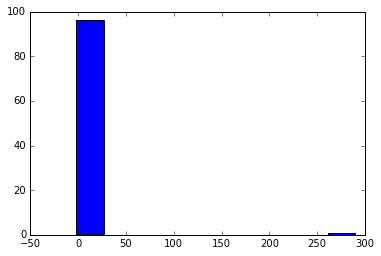

In [22]:
plt.hist(SNR[:,1])

(array([ 69.,  17.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.62656793e-01,   2.91348265e+01,   5.81069962e+01,
          8.70791660e+01,   1.16051336e+02,   1.45023505e+02,
          1.73995675e+02,   2.02967845e+02,   2.31940015e+02,
          2.60912184e+02,   2.89884354e+02]),
 <a list of 10 Patch objects>)

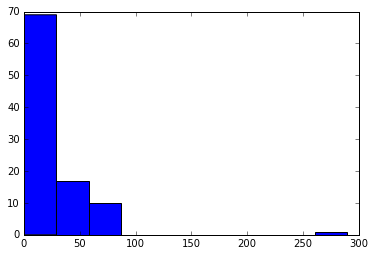

In [23]:
plt.hist(SNR[:,0])